<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**
Nafis Neehal (661990881) \\
Graduate Student, Department of CS, RPI

#**Imports**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score 

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [3]:
data = pd.read_csv("./drive/MyDrive/ML Project Course/HW2/data.csv")

In [4]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#**Data Analysls**

Observations:


*   Data has a mix of categorical, continuous and binary data
*   Data in highly disruptive different scales for - Age, Avg Glucose Level and BMI
* BMI has sufficient amount of missing values, discarding all will result in significant information loss
* The Target Variable is "Stroke" - which is highly imbalanced.



In [5]:
data.work_type.unique(), data.Residence_type.unique(), data.smoking_status.unique()

(array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
       dtype=object),
 array(['Urban', 'Rural'], dtype=object),
 array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
       dtype=object))

Missing BMI value counts

In [6]:
data.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [7]:
data.bmi.isna().sum()

201

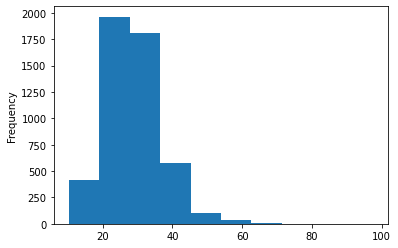

In [8]:
data.bmi.plot(kind='hist')

Class Imbalance:
* negative samples: 4861
* postive samples: 249


In [9]:
data.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

#**Data Transformation**

Convert Categorical Data into numeric representations via mapping

In [10]:
data.gender = data.gender.replace(["Male","Female", "Other"],[1,0,2])

In [11]:
data.ever_married = data.ever_married.replace(["Yes","No"],[1,0])

In [12]:
data.Residence_type = data.Residence_type.replace(["Urban","Rural"],[1,0])

Mapping for work_type feature: \\
0=Govt_Job, 1=Never_Worked , 2=Private, 3=Self Employed,  4=Children, 

In [13]:
data.work_type = data.work_type.astype('category').cat.codes

Mapping for smoking_status feature: \\
0= 'Unknown', 1= 'formerly smoked', 2= 'never smoked', 3='smokes'

In [14]:
data.smoking_status = data.smoking_status.astype('category').cat.codes

Replacing missing BMIs with its nearest neighbor's BMI value based on all features except BMI. ID is not a feature.

*   Divide data into two sets, one with where all BMI values are present (A) and other with all BMI values as Nans (B)
*   For each sample x in B, find the nearest neighbor x_n in A, and then replace x's BMI value with x_n's BMI value. It would be more robust though if we would have taken multiple neighbors and then take the average. But for this simple non-sophisticated problem, this simpler design choice performed just as well.



In [15]:
nan_ids = data[data.bmi.isna()].index.values
non_nan_ids = np.setdiff1d(data.index.values, nan_ids)

In [16]:
from sklearn.neighbors import NearestNeighbors
NB = NearestNeighbors(n_neighbors=1, radius=0.2)
query_db = data[data.index.isin(non_nan_ids)].loc[:,'gender':'smoking_status'].drop(columns=['bmi'])
NB.fit(query_db.values)
for id in nan_ids:
  nan_sample = data.loc[id,'gender':'smoking_status'].drop(labels=['bmi'])
  nb_index_val = NB.kneighbors(nan_sample.values.reshape(1,-1), n_neighbors=1, return_distance=False)
  nb_sample = data.loc[nb_index_val[-1],:]
  data.loc[id,'bmi'] = nb_sample.bmi.values[-1]

 Really make sure that somehow no more NaNs remain in data

In [17]:
data = data.dropna()

Standardize three features that have disruptively different scale - age, avg_glucose_level and bmi.

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
data[['age','avg_glucose_level', 'bmi']] = scaler.fit_transform(data[['age','avg_glucose_level', 'bmi']])

In [19]:
features = data.loc[:,'gender':'smoking_status'].columns.to_list()
labels = ['0', '1']
X = data.loc[:,'gender':'smoking_status'].values
Y = data.stroke.values.reshape(X.shape[0], 1)

Handle the imbalance in class labels: One effective way would be to do oversampling the minority class. 
Using SMOTE algorithm for oversampling: https://imbalanced-learn.org/stable/over_sampling.html

In [20]:
from imblearn.over_sampling import SMOTE
X_smote, Y_smote = SMOTE().fit_resample(X, Y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

Final Data is in far better shape now.

In [21]:
np.unique(Y_smote, return_counts=True)

(array([0, 1]), array([4858, 4858]))

Data Split into Training and Test in 80:20 ratio

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, Y_smote, test_size=0.20, random_state=42)

In [23]:
X_train.shape, X_test.shape

((7772, 10), (1944, 10))

# **FUNCTIONS**

In [24]:
def plot_tree(crit, split, depth, min_split, min_leaf):
  estimator = DecisionTreeClassifier(random_state = 0, 
                                     criterion = crit, 
                                     splitter = split, 
                                     max_depth = depth, 
                                     min_samples_split=min_split,
                                     min_samples_leaf=min_leaf)
  
  estimator.fit(X_smote, Y_smote)

  graph = Source(tree.export_graphviz(estimator
        , out_file=None
        , feature_names=features
        , class_names=labels
        , filled = True))
   
  display(SVG(graph.pipe(format='svg')))
  return estimator


In [25]:
def plot(X, Y, xlabel, ylabel, title):
  plt.plot(X,Y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [26]:
def performance(clf):
  Training_Acc = clf.score(X_train, y_train)
  Test_Acc = clf.score(X_test, y_test)

  print(f"Training Accuracy: {Training_Acc:0.5f}")
  print(f"Test Accuracy: {Test_Acc: 0.5f}")

  return Training_Acc, Test_Acc

# **1. Decision Tree using Scikit Learn**
Here we have used Decision Tree Classifier implementation from Scikit-Learn. We have constructed an well defined parameter search space around the default values and have used GridSearchCV from Scikit-Learn for browsing this hyperspace and returning us the best estimator. As this is a binary classification problem, using "Accuracy" as metric is the obvious choice here.

In [27]:
param_grid = {
            'criterion':['gini', 'entropy'],
            'max_depth':[2, 3, 5, 10, 20, 50, 60, 100],
            'class_weight':['balanced'],
            'min_impurity_decrease':[0.0, 0.0001, 0.001, 0.01]
         }

GSCV_clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='accuracy')
GSCV_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
          

Grid Search CV returns us the best estimator.

In [28]:
DT_clf = GSCV_clf.best_estimator_
DT_clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')

Best Params returned from Grid Search CV.

In [48]:
GSCV_clf.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 50,
 'min_impurity_decrease': 0.0}

Performance of the Best Estimator. We can see that the model overfits the training data by a very slight margin. To improve this, Bagging Classifiers would definitely help.

In [29]:
DT_Training_Acc, DT_Test_Acc = performance(DT_clf)

Training Accuracy: 1.00000
Test Accuracy:  0.91718


**Ddecision Tree Hyperparatemeter Tuning: Max_Depth**
Here we observe the most crucial hyper-parameter of a Decision Tree algorithm, which highly influences the algorithm performance. As we can see below, increasing the max-depth increases the accuracy of the model both on training and test set upto a certain point, and then the curve gets flattened. This point should be chosen as the optimal cut-off point and the tree should be pruned beyond that level. If we don't control for this variable, and set max_depth too high, then the decision tree might simply overfit the training data without capturing useful patterns as we would like; this will cause testing error to increase. If we look closely, Max_Depth=50 is the optimal choice here, after which the curve completely flattens.

In [30]:
max_depth = [2, 3, 5, 10, 20, 50, 60, 100]
tr = []
te = []
for dpt in max_depth:
  Base_DT_Clf = tree.DecisionTreeClassifier(max_depth=dpt, random_state=0).fit(X_train, y_train)
  trd, ted = performance(Base_DT_Clf)
  tr.append(trd)
  te.append(ted)

Training Accuracy: 0.76711
Test Accuracy:  0.76543
Training Accuracy: 0.77342
Test Accuracy:  0.76955
Training Accuracy: 0.81922
Test Accuracy:  0.80761
Training Accuracy: 0.91109
Test Accuracy:  0.88529
Training Accuracy: 0.99331
Test Accuracy:  0.92181
Training Accuracy: 1.00000
Test Accuracy:  0.92901
Training Accuracy: 1.00000
Test Accuracy:  0.92901
Training Accuracy: 1.00000
Test Accuracy:  0.92901


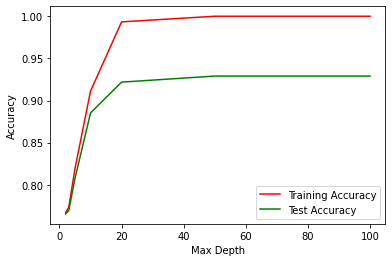

In [31]:
plt.plot(max_depth, tr, color='r', label="Training Accuracy")
plt.plot(max_depth, te, color='g', label="Test Accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Optional (Must RUN on COLAB) - Live Hyperpatameter Tuning: Visualize the best Esitmator and Decision Criteria**
This is an optional visual representation of Decision Tree. We can tune the hyperparameters here, and visualize the decision tree LIVE. Here, I have shown a smaller pruned version of the final decision tree.

In [32]:
inter=interactive(plot_tree, 
                  crit = ["gini", "entropy"], 
                  split = ["best", "random"], 
                  depth=[2, 3, 5, 10, 20, 50, 60, 100],
                  min_split=[2],
                  min_leaf=[0.1, 0.5, 1])

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# **2. Bagging**
We implement Bagging Classifier here with a hope that the marginally high variance due to overfitting effect we saw with the baseline model will be reduced. We implemenent Bagging classifier with K-Fold CV where we chose K=10 which has been historically proven to be a good choice for smaller problems. 

In [33]:
cv_KFold = KFold(n_splits=10, shuffle=False)

In [34]:
mean_acc = []
no_estimators = []
for i in range(10, 101, 10):
  BAG_clf = BaggingClassifier(DT_clf, n_estimators=i, random_state=42).fit(X_train, y_train)
  cv_clf = cross_val_score(BAG_clf, X_train, y_train, scoring='accuracy', cv=cv_KFold)
  mean_acc.append(cv_clf.mean())
  no_estimators.append(i)
  print(f"Aggregated (Mean) Training Accuracy for {i} Bagged estimators:{cv_clf.mean():0.05f}")

Aggregated (Mean) Training Accuracy for 10 Bagged estimators:0.95291
Aggregated (Mean) Training Accuracy for 20 Bagged estimators:0.95934
Aggregated (Mean) Training Accuracy for 30 Bagged estimators:0.96140
Aggregated (Mean) Training Accuracy for 40 Bagged estimators:0.96101
Aggregated (Mean) Training Accuracy for 50 Bagged estimators:0.96076
Aggregated (Mean) Training Accuracy for 60 Bagged estimators:0.96140
Aggregated (Mean) Training Accuracy for 70 Bagged estimators:0.96179
Aggregated (Mean) Training Accuracy for 80 Bagged estimators:0.96166
Aggregated (Mean) Training Accuracy for 90 Bagged estimators:0.96191
Aggregated (Mean) Training Accuracy for 100 Bagged estimators:0.96204


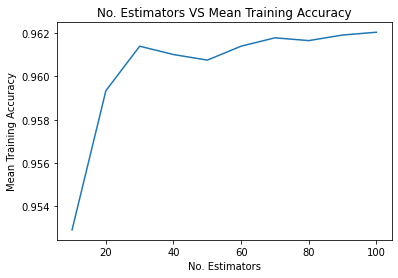

In [35]:
plot(no_estimators, mean_acc, "No. Estimators", "Mean Training Accuracy", "No. Estimators VS Mean Training Accuracy")

We choose n_estimators=40 because after that the improvement becomes very negligible.

In [36]:
Final_BAG_clf = BaggingClassifier(DT_clf, n_estimators=40, random_state=42).fit(X_train, y_train)

We observe that after bagging 40 Decision Tree models together, we get much better accuracy on Test set, reducing the overfitting effect to a high extent.

In [37]:
Bag_Training_Acc, Bag_Test_Acc = performance(Final_BAG_clf)

Training Accuracy: 1.00000
Test Accuracy:  0.96708


# **`3. Boosting`**

In [38]:
cv_KFold = KFold(n_splits=10, shuffle=False)

In [66]:
mean_acc = []
no_estimators = []
for i in range(10, 51, 10):
  BOO_clf = AdaBoostClassifier(DT_clf, n_estimators=i, learning_rate=0.01, random_state=42).fit(X_train, y_train)
  cv_clf = cross_val_score(BOO_clf, X_train, y_train, scoring='accuracy', cv=cv_KFold)
  mean = cv_clf.mean()
  mean_acc.append(mean)
  no_estimators.append(i)
  print(f"Aggregated (Mean) Training Accuracy for {i} Boosted estimators:{mean.item(0):0.05f}")

Aggregated (Mean) Training Accuracy for 10 Boosted estimators:0.92087
Aggregated (Mean) Training Accuracy for 20 Boosted estimators:0.92087
Aggregated (Mean) Training Accuracy for 30 Boosted estimators:0.92087
Aggregated (Mean) Training Accuracy for 40 Boosted estimators:0.92087
Aggregated (Mean) Training Accuracy for 50 Boosted estimators:0.92087


We observe that, as expected, Boosting algorithms are not performing very well in this case there is very negligible bias to remove. As a matter of fact, the best DT estimator that we pass in AdaBoost as base_estimator has already converged to its optimal result, hence there is absolutely no improvement visible in terms of accuracy. We therefore chose the lowest number of n_estimator hence in this case to reduce the model complexity.

In [67]:
Final_BOO_clf = AdaBoostClassifier(DT_clf, n_estimators=10, random_state=42).fit(X_train, y_train)

In [68]:
Boo_Training_Acc, Boo_Test_Acc = performance(Final_BOO_clf)

Training Accuracy: 1.00000
Test Accuracy:  0.92438


**Comment on Difference/Similarity in results of Bagging and Boosting**
Bagging methods usually improves model by controlling for overfitting, so the model has to have non-negligible high-variance to see improvement. That's exactly what we saw in our Bagging Classifier Implementation. \\
Whereas, Boosting methods usually improves model by controlling for underfitting, so the model has to have non-negligible high-bias to see improvement. We don't have significant amount of Bias here in this model. Hence, we don't see any sort of improvement using Boosting algorithms with the best DT Estimator as base_estimator. \\
If we would have instead use just a random DT Estimator from scratch which hasn't converged yet, we definitely would have seen visible improvements. \\
See the Simualtion below:

In [76]:
mean_acc = []
no_estimators = []
for i in range(10, 101, 10):
  BOO_clf = AdaBoostClassifier(n_estimators=i, learning_rate=0.01, random_state=42).fit(X_train, y_train)
  cv_clf = cross_val_score(BOO_clf, X_train, y_train, scoring='accuracy', cv=cv_KFold)
  mean = cv_clf.mean()
  mean_acc.append(mean)
  no_estimators.append(i)
  print(f"Aggregated (Mean) Training Accuracy for {i} Boosted estimators:{mean.item(0):0.05f}")

Aggregated (Mean) Training Accuracy for 10 Boosted estimators:0.76699
Aggregated (Mean) Training Accuracy for 20 Boosted estimators:0.76699
Aggregated (Mean) Training Accuracy for 30 Boosted estimators:0.76686
Aggregated (Mean) Training Accuracy for 40 Boosted estimators:0.76621
Aggregated (Mean) Training Accuracy for 50 Boosted estimators:0.76660
Aggregated (Mean) Training Accuracy for 60 Boosted estimators:0.76904
Aggregated (Mean) Training Accuracy for 70 Boosted estimators:0.77007
Aggregated (Mean) Training Accuracy for 80 Boosted estimators:0.77059
Aggregated (Mean) Training Accuracy for 90 Boosted estimators:0.77187
Aggregated (Mean) Training Accuracy for 100 Boosted estimators:0.77187


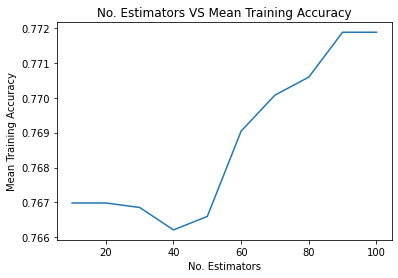

In [77]:
plot(no_estimators, mean_acc, "No. Estimators", "Mean Training Accuracy", "No. Estimators VS Mean Training Accuracy")

# **4. Result Compare on Chosen Metric: Accuracy**

In [69]:
Model = ["Decision Tree", "Bagging Classifier", "Boosting Classifier"]
Tr_acc = [DT_Training_Acc, Bag_Training_Acc, Boo_Training_Acc]
Te_acc = [DT_Test_Acc, Bag_Test_Acc, Boo_Test_Acc]
Res = pd.DataFrame({"Model":Model,
                    "Training Accuracy": Tr_acc,
                    "Test Accuracy": Te_acc})

In [70]:
Res

,Model,Training Accuracy,Test Accuracy
0,Decision Tree,1.0,0.917181
1,Bagging Classifier,1.0,0.967078
2,Boosting Classifier,1.0,0.924383


**Discussion:**


1.   Performance Comparison: If we look at only test accuracy (all have the same training accuracy), then Bagging Classifier is the clear winner here. It also makes sense, because Bagging Classifiers usually improve the performance of models having high variance. Initially, we saw that a marginal overfitting exists for the base DT model. Bagging Classifier improves it to a great extent which is reflected by the performance on test data. 
2.   Why Accuracy is the best choice for Metric in this case: This is a binary classification problem. Also although at the beginning classes were imbalanced, but we then balanced it doing Oversampling using SMOTE. It is also easy and straightforward to interpret. Hence Accuracy is the obvious choice.



# **5. Alternative Metric: Precision, Recall, F1 Score**
Here we explore three alternative metrics - Precision, Recall and F1 Score.

In [71]:
from sklearn.metrics import precision_recall_fscore_support

In [72]:
Metric = ["Precision", "Recall", "F1 Measure"]
DT  = list(precision_recall_fscore_support(y_test, DT_clf.predict(X_test), average='macro'))[:3]
BAG = list(precision_recall_fscore_support(y_test, Final_BAG_clf.predict(X_test), average='macro'))[:3]
BOO = list(precision_recall_fscore_support(y_test, Final_BOO_clf.predict(X_test), average='macro'))[:3]
Alt_Res = pd.DataFrame({"Metric":Metric,
                    "Decision Tree":DT,
                    "Bagging Classifier":BAG,
                    "Boosting Classifier":BOO
                    })

In [73]:
Alt_Res

,Metric,Decision Tree,Bagging Classifier,Boosting Classifier
0,Precision,0.917448,0.967056,0.924752
1,Recall,0.917380,0.967100,0.924610
2,F1 Measure,0.917181,0.967074,0.924381


**Discussion:**

* Precision: Precision talks about how precise/accurate our model is - out of the predicted positives, how many of them are actual positive. Precision is a good measure to determine, when the costs of False Positive is high. In our case, Precision is not that important, because False Negative would have highest cost in our case (If patient is diagnosed to have no stroke and than gets the stroke). But, anyway, in all case the higher the precision, the better. In our case we can see that Bagging classifier has the highest precision.

* Recall: Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). In our case, higher the recall, the better, because lower the False Negatives. And this is very significant. We see that Bagging classifier again has the highest recall. 

* F1 Measure: This is a balanced representation of precision and recall. The higher the value of F1 measure, the better. We see in our case, Bagging Classifier has the highest F1 Measure.

* *When would these metrics would be more useful:* If we would have kept our data labeles imbalanced, then accuracy would have always been very high, so our results would be misleading. But these three metrics would be helpful in that case because they would have captured the true performance of the model inspite of the imbalance in class labels.
